必要ModuleをImport

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import math

import random
import time
import pickle
import tqdm
from collections import Counter

from torch.utils.data import Dataset
import numpy as np

from utils import GELU, PositionwiseFeedForward, LayerNorm, SublayerConnection, LayerNorm

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from ipywidgets import FloatProgress
from IPython.display import display, clear_output

from dataset import BERTDataset

read_dirでディレクトリを指定<br>
このディレクトリ内のコーパスを読み込む<br>
vocabファイルもここに作成される

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#read_dir = './data/single/'
read_dir = './data/merged_bert/'
#output_dir = './output/single/'
output_dir = './output/merged_bert/mlm/mid/'
tag = 'kana'
processed_train_txt = read_dir + 'train_X.txt'
processed_valid_txt = read_dir + 'valid_X.txt'
processed_test_txt = read_dir + 'test_X.txt'

Attentionセルを定義する

In [4]:
class Attention(nn.Module):
    """
    Scaled Dot Product Attention
    """
    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn


Multi Head Attentionを定義する

In [5]:
class MultiHeadedAttention(nn.Module):

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linear_layers, (query, key, value))]

        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)


Transformerを定義する

In [6]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """
    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """
        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)


BERTクラスを定義する

In [7]:
class BERT(nn.Module):

    def __init__(self, vocab_size, hidden=768, n_layers=12, attn_heads=12, dropout=0.1):
        """
        :param vocab_size: vocab_size of total words
        :param hidden: BERT model hidden size
        :param n_layers: numbers of Transformer blocks(layers)
        :param attn_heads: number of attention heads
        :param dropout: dropout rate
        """
        super().__init__()
        self.hidden = hidden
        self.n_layers = n_layers
        self.attn_heads = attn_heads
        self.feed_forward_hidden = hidden * 4
        # embedding for BERT
        self.embedding = BERTEmbedding(vocab_size=vocab_size, embed_size=hidden, dropout=dropout)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(hidden, attn_heads, hidden * 4, dropout) for _ in range(n_layers)])

    def forward(self, x):
        # xの中で0以上は1, 0未満は0として, maskテンソルを作る
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)
        x = self.embedding(x)

        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)
        return x


BERTのEmbedding層を定義する

In [8]:
class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super().__init__(vocab_size, embed_size, padding_idx=0)

class PositionalEmbedding(nn.Module):

    def __init__(self, d_model, max_len=512):
        super().__init__()

        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)).float().exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : 通常のEMbedding
        2. PositionalEmbedding : sin, cosを用いた位置情報付きEmbedding
        2. SegmentEmbedding : Sentenceのセグメント情報 (sent_A:1, sent_B:2)
    """
    def __init__(self, vocab_size, embed_size, dropout=0.1):
        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(d_model=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    #def forward(self, sequence, segment_label):
    def forward(self, sequence):
        x = self.token(sequence) + self.position(sequence)
        return self.dropout(x)


学習用にマスク予測の層を追加する<br>
Next Sentence Prediction用のクラスは削除してある

In [9]:
class BERTLM(nn.Module):
    """
    BERT Language Model
    Masked Language Model only
    """

    def __init__(self, bert: BERT, vocab_size):
        """
        :param bert: BERT model which should be trained
        :param vocab_size: total vocab size for masked_lm
        """
        super().__init__()
        self.bert = bert
        self.mask_lm = MaskedLanguageModel(self.bert.hidden, vocab_size)

    def forward(self, x):
        x = self.bert(x)
        return self.mask_lm(x)

class MaskedLanguageModel(nn.Module):
    """
    入力系列のMASKトークンから元の単語を予測する
    nクラス分類問題, nクラス : vocab_size
    """
    def __init__(self, hidden, vocab_size):
        """
        :param hidden: output size of BERT model
        :param vocab_size: total vocab size
        """
        super().__init__()
        self.linear = nn.Linear(hidden, vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        return self.softmax(self.linear(x))

BERT用のVocabを生成するクラスを定義する

In [10]:
import pickle
import tqdm
from collections import Counter

class TorchVocab(object):
    """
    :property freqs: collections.Counter, コーパス中の単語の出現頻度を保持するオブジェクト
    :property stoi: collections.defaultdict, string → id の対応を示す辞書
    :property itos: collections.defaultdict, id → string の対応を示す辞書
    """
    def __init__(self, counter, max_size=None, min_freq=1, specials=['<pad>', '<oov>'],
                 vectors=None, unk_init=None, vectors_cache=None):
        """
        :param coutenr: collections.Counter, データ中に含まれる単語の頻度を計測するためのcounter
        :param max_size: int, vocabularyの最大のサイズ. Noneの場合は最大値なし. defaultはNone
        :param min_freq: int, vocabulary中の単語の最低出現頻度. この数以下の出現回数の単語はvocabularyに加えられない.
        :param specials: list of str, vocabularyにあらかじめ登録するtoken
        :param vecors: list of vectors, 事前学習済みのベクトル. ex)Vocab.load_vectors
        """
        self.freqs = counter
        counter = counter.copy()
        min_freq = max(min_freq, 1)

        self.itos = list(specials)
        # special tokensの出現頻度はvocabulary作成の際にカウントされない
        for tok in specials:
            del counter[tok]

        max_size = None if max_size is None else max_size + len(self.itos)

        # まず頻度でソートし、次に文字順で並び替える
        words_and_frequencies = sorted(counter.items(), key=lambda tup: tup[0])
        words_and_frequencies.sort(key=lambda tup: tup[1], reverse=True)
        
        # 出現頻度がmin_freq未満のものはvocabに加えない
        for word, freq in words_and_frequencies:
            if freq < min_freq or len(self.itos) == max_size:
                break
            self.itos.append(word)

        # dictのk,vをいれかえてstoiを作成する
        self.stoi = {tok: i for i, tok in enumerate(self.itos)}

        self.vectors = None
        if vectors is not None:
            self.load_vectors(vectors, unk_init=unk_init, cache=vectors_cache)
        else:
            assert unk_init is None and vectors_cache is None

    def __eq__(self, other):
        if self.freqs != other.freqs:
            return False
        if self.stoi != other.stoi:
            return False
        if self.itos != other.itos:
            return False
        if self.vectors != other.vectors:
            return False
        return True

    def __len__(self):
        return len(self.itos)

    def vocab_rerank(self):
        self.stoi = {word: i for i, word in enumerate(self.itos)}

    def extend(self, v, sort=False):
        words = sorted(v.itos) if sort else v.itos
        for w in words:
            if w not in self.stoi:
                self.itos.append(w)
                self.stoi[w] = len(self.itos) - 1


class Vocab(TorchVocab):
    def __init__(self, counter, max_size=None, min_freq=1):
        self.pad_index = 0
        self.unk_index = 1
        self.eos_index = 2
        self.sos_index = 3
        self.mask_index = 4
        super().__init__(counter, specials=["<pad>", "<unk>", "<eos>", "<sos>", "<mask>"], max_size=max_size, min_freq=min_freq)

    # override用
    def to_seq(self, sentece, seq_len, with_eos=False, with_sos=False) -> list:
        pass

    # override用
    def from_seq(self, seq, join=False, with_pad=False):
        pass

    @staticmethod
    def load_vocab(vocab_path: str) -> 'Vocab':
        with open(vocab_path, "rb") as f:
            return pickle.load(f)

    def save_vocab(self, vocab_path):
        with open(vocab_path, "wb") as f:
            pickle.dump(self, f)


# テキストファイルからvocabを作成する
class WordVocab(Vocab):
    def __init__(self, texts, max_size=None, min_freq=1):
        print("Building Vocab")
        counter = Counter()
        for line in texts:
            if isinstance(line, list):
                words = line
            else:
                words = line.replace("\n", "").replace("\t", "").split()

            for word in words:
                counter[word] += 1
        super().__init__(counter, max_size=max_size, min_freq=min_freq)

    def to_seq(self, sentence, seq_len=None, with_eos=False, with_sos=False, with_len=False):
        if isinstance(sentence, str):
            sentence = sentence.split()

        seq = [self.stoi.get(word, self.unk_index) for word in sentence]

        if with_eos:
            seq += [self.eos_index]  # this would be index 1
        if with_sos:
            seq = [self.sos_index] + seq

        origin_seq_len = len(seq)

        if seq_len is None:
            pass
        elif len(seq) <= seq_len:
            seq += [self.pad_index for _ in range(seq_len - len(seq))]
        else:
            seq = seq[:seq_len]

        return (seq, origin_seq_len) if with_len else seq

    def from_seq(self, seq, join=False, with_pad=False):
        words = [self.itos[idx]
                 if idx < len(self.itos)
                 else "<%d>" % idx
                 for idx in seq
                 if not with_pad or idx != self.pad_index]

        return " ".join(words) if join else words

    @staticmethod
    def load_vocab(vocab_path: str) -> 'WordVocab':
        with open(vocab_path, "rb") as f:
            return pickle.load(f)


def build(corpus_path, output_path, vocab_size=None, encoding='utf-8', min_freq=1):
    with open(corpus_path, "r", encoding=encoding) as f:
        vocab = WordVocab(f, max_size=vocab_size, min_freq=min_freq)

    print("VOCAB SIZE:", len(vocab))
    vocab.save_vocab(output_path)

Dataloaderを定義する.<br>
ここで文章中の単語をMASKする処理を行う<br>
Windowsでの並列化処理のために外部ファイル(dataset.py)で定義する  
MACやLinuxならこのipynbに直接定義しても良いはず

Trainerクラスを定義する.  
Masked Language Model : 文章中の一部の単語をマスクして,予測を行うタスク.  
- `save_bert`はbert本体のみを保存する
- `save_pretrain`は事前学習用のHeadも含んだ全体を保存する
- `load_bert`と`load_pretrain`も同様

In [11]:
from collections import OrderedDict
class BERTTrainer:
    def __init__(self, bert: BERT, vocab_size: int,
                 train_dataloader: DataLoader, valid_dataloader: DataLoader = None,
                 lr: float = 1e-4, betas=(0.9, 0.999), weight_decay: float = 0.01,
                 with_cuda: bool = True, log_freq: int = 10):
        # GPU環境において、GPUを指定しているかのフラグ
        cuda_condition = torch.cuda.is_available() and with_cuda
        self.device = torch.device("cuda:0" if cuda_condition else "cpu")

        self.bert = bert
        self.model = BERTLM(bert, vocab_size).to(self.device)

        if torch.cuda.device_count() > 1:
            print("Using %d GPUS for BERT" % torch.cuda.device_count())
            self.model = nn.DataParallel(self.model)

        self.train_data = train_dataloader
        self.valid_data = valid_dataloader

        self.optim = Adam(self.model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

        # masked_token予測のためのLoss関数を設定
        self.criterion = nn.NLLLoss()
        self.log_freq = log_freq
        print("Total Parameters:", sum([p.nelement() for p in self.model.parameters()]))
        
        self.train_losses = []
        self.valid_losses = []
        self.train_accs = []
        self.valid_accs = []

    def train(self, epoch):
        self.iteration(epoch, self.train_data)

    def valid(self, epoch):
        self.iteration(epoch, self.valid_data, train=False)

    def iteration(self, epoch, data_loader, train=True):
        """
        :param epoch: 現在のepoch
        :param data_loader: torch.utils.data.DataLoader
        :param train: trainかtestかのbool値
        """
        str_code = "train" if train else "valid"
        data_iter = tqdm.tqdm(enumerate(data_loader), desc="EP_%s:%d" % (str_code, epoch), total=len(data_loader), bar_format="{l_bar}{r_bar}")
        avg_loss = 0.0
        total_correct = 0
        total_element = 0

        for i, data in data_iter:
            # 0. batch_dataはGPU or CPUに載せる
            data = {key: value.to(self.device) for key, value in data.items()}
            # 1. forward the next_sentence_prediction and masked_lm model
            mask_lm_output = self.model.forward(data["bert_input"])
            # 2-2. NLLLoss(negative log likelihood) : predicting masked token word
            mask_loss = self.criterion(mask_lm_output.transpose(1, 2), data["bert_label"])
            # 2-3. next_lossとmask_lossの合計をlossとする
            loss = mask_loss
            # 3. training時のみ,backwardとoptimizer更新を行う
            if train:
                self.optim.zero_grad()
                loss.backward()
                self.optim.step()

            correct = mask_lm_output.argmax(dim=-1).eq(data["bert_label"]).sum().item()
            avg_loss += loss.item()
            total_element += data["bert_label"].nelement() * 128
            total_correct += correct
            post_fix = {
                "epoch": epoch,
                "iter": i,
                "avg_loss": avg_loss / (i + 1),
                "avg_acc": total_correct / total_element * 100,
                "loss": loss.item()
            }

            if i % self.log_freq == 0:
                data_iter.write(str(post_fix))
            
        if train:
            self.train_losses.append(avg_loss / len(data_iter))
            self.train_accs.append(total_correct * 100.0 / total_element)
        else:
            self.valid_losses.append(avg_loss / len(data_iter))
            self.valid_accs.append(total_correct * 100.0 / total_element)

        print("EP%d_%s, avg_loss=" % (epoch, str_code), avg_loss / len(data_iter))

        
    def save_bert(self, epoch, file_path=output_dir + "bert"):
        output_path = file_path + ".ep%d" % epoch
        torch.save(self.bert.state_dict(), output_path)
        self.bert.to(self.device)
        print("EP:%d Model Saved on:" % epoch, output_path)
        return output_path
    
    def save_pretrain(self, epoch, file_path=output_dir + "mlm"):
        state = {
            'epoch' : epoch,
            'state_dict' : self.model.module.state_dict(),
            'optimizer' : self.optim.state_dict(),
            'train_loss' : self.train_losses,
            'valid_loss' : self.valid_losses
        }
        output_path = file_path + ".ep%d" % epoch
        torch.save(state, output_path)
        self.bert.to(self.device)
        print("EP:%d Model Saved on:" % epoch, output_path)
        return output_path
 
    def load_bert(self, file_path):
        self.bert.state_dict(torch.load(file_path))
        
    def load_pretrain(self, file_path):
        state = torch.load(file_path)
        self.model.module.load_state_dict(state['state_dict'])
        self.optim.load_state_dict(state['optimizer'])
        self.train_losses = state['train_loss']
        self.valid_losses = state['valid_loss']
        return state

In [12]:
import datetime
dt_now = str(datetime.datetime.now()).replace(' ', '')
dt_now = dt_now.replace(':','_')

In [13]:
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
import numpy as np
plt.style.use('ggplot')

def showPlot(points):

    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    #loc = ticker.MultipleLocator(base=0.2)
    #ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.show()
    
def savePlot(points, figure_path):
    plt.switch_backend('Agg')
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.savefig(figure_path)

* 最初から学習する場合：`train_mode = 'first'`  
* 途中から学習を再開する場合：`train_mode = 'continue'`  
    - 保存してある学習済みモデルのパスを指定する
    - vocabファイルのパスを指定する

In [14]:
# 訓練用パラメタを定義する
train_dataset=processed_train_txt
valid_dataset=processed_valid_txt
test_dataset=processed_test_txt
vocab_path= read_dir + 'vocab.txt'
output_model_path= output_dir

hidden=256 #768
layers=4 #12
attn_heads= 8 #12
seq_len=128

batch_size=128
epochs=16
num_workers=0
with_cuda=True
log_freq=100
corpus_lines=None

lr=1e-3
adam_weight_decay=0.00
adam_beta1=0.9
adam_beta2=0.999

dropout=0.0

min_freq=7

corpus_path=processed_train_txt
label_path=None

# 最初から学習する場合は'first'、学習を続きから再開する場合は'continue'
#train_mode = 'first' 
train_mode = 'continue' 

In [15]:
#if train_mode == 'first':
#build(corpus_path, vocab_path, min_freq=min_freq)

print("Loading Vocab", vocab_path)
vocab = WordVocab.load_vocab(vocab_path)

print("Loading Train Dataset", train_dataset)
train_dataset = BERTDataset(train_dataset, vocab, seq_len=seq_len, label_path=label_path, corpus_lines=corpus_lines)

print("Loading Valid Dataset", valid_dataset)
valid_dataset = BERTDataset(valid_dataset, vocab, seq_len=seq_len, label_path=label_path) if valid_dataset is not None else None

print("Creating Dataloader")
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_data_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers) if valid_dataset is not None else None

print("Building BERT model")
bert = BERT(len(vocab), hidden=hidden, n_layers=layers, attn_heads=attn_heads, dropout=dropout)
trainer = BERTTrainer(bert, len(vocab), train_dataloader=train_data_loader, valid_dataloader=valid_data_loader,
                  lr=lr, betas=(adam_beta1, adam_beta2), weight_decay=adam_weight_decay,
                  with_cuda=with_cuda, log_freq=log_freq)
if train_mode == 'first':
    trained_epoch = 0
else:
    state = trainer.load_pretrain(output_dir + '.ep16')
    trained_epoch = state['epoch']+1
#trainer.save_bert(0, output_dir + 'bert')

Building Vocab
VOCAB SIZE: 4607
Loading Vocab ./data/merged_bert/vocab.txt
Loading Train Dataset ./data/merged_bert/train_X.txt
Loading Valid Dataset ./data/merged_bert/valid_X.txt
Creating Dataloader
Building BERT model
Using 2 GPUS for BERT
Total Parameters: 5522431


RuntimeError: Error(s) in loading state_dict for BERTLM:
	size mismatch for bert.embedding.token.weight: copying a param with shape torch.Size([4608, 256]) from checkpoint, the shape in current model is torch.Size([4607, 256]).
	size mismatch for mask_lm.linear.weight: copying a param with shape torch.Size([4608, 256]) from checkpoint, the shape in current model is torch.Size([4607, 256]).
	size mismatch for mask_lm.linear.bias: copying a param with shape torch.Size([4608]) from checkpoint, the shape in current model is torch.Size([4607]).

In [15]:
print("Training Start")
for epoch in range(trained_epoch, epochs):
    epoch_start = time.time()
    trainer.train(epoch)
    # Model Save
    trainer.save_pretrain(epoch, output_model_path)
    trainer.valid(epoch)
    print(time.time() - epoch_start)
    showPlot(trainer.train_losses)
    showPlot(trainer.valid_losses)
    
#savePlot(trainer.train_losses, "./results/"+str(epochs)+"_train.png")
#savePlot(trainer.valid_losses, "./results/"+str(epochs)+"_valid.png")

Training Start


In [16]:
def save_results():
    with open(output_dir + "results.txt","w",encoding='utf-8') as f:
        f.write("----------Parameters list----------\n")
        f.write("hidden=" +str(hidden) + "\n")
        f.write("layers="+str(layers)+"\n")
        f.write("attn_heads="+str(attn_heads)+"\n")
        f.write("seq_len="+str(seq_len)+"\n")
        f.write("batch_size="+str(batch_size)+"\n")
        f.write("epochs="+str(epochs)+"\n")
        f.write("lr="+str(lr)+"\n")
        f.write("\n")
        
        f.write("-"*10+"Train Loss"+"-"*10+"\n")
        f.write(str(trainer.train_losses[-1]))
        f.write("\n")
        
        f.write("-"*10+"Valid Loss"+"-"*10+"\n")
        f.write(str(trainer.valid_losses[-1]))
        f.write("\n")
        
        f.write("-"*10+"Train Acc"+"-"*10+"\n")
        f.write(str(trainer.train_accs[-1]))
        f.write("\n")
        
        f.write("-"*10+"Valid Acc"+"-"*10+"\n")
        f.write(str(trainer.valid_accs[-1]))
    savePlot(trainer.train_accs, output_dir + "train_accs")
    savePlot(trainer.valid_accs, output_dir + "valid_accs")
    savePlot(trainer.train_losses, output_dir + "train_losses")
    savePlot(trainer.valid_losses, output_dir + "valid_losses")
#save_results()

# パラメータ
# Loss　Acc
#　


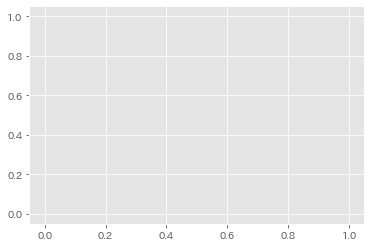

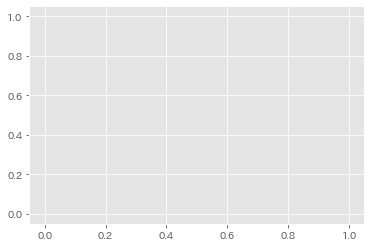

In [17]:
showPlot(trainer.train_accs)
showPlot(trainer.valid_accs)

In [18]:
test_dataset = BERTDataset(processed_test_txt, vocab, seq_len=seq_len, label_path=label_path, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=num_workers, shuffle=False)

In [20]:
hiragana = "ぁあぃいぅうぇえぉおかがきぎくぐけげこごさざしじすずせぜそぞただちぢっつづてでとどなにぬねのはばぱひびぴふぶぷへべぺほぼぽまみむめもゃやゅゆょよらりるれろゎわをん"
hiragana = [vocab.stoi.get(token, vocab.unk_index) for token in hiragana]
trainer.model.eval()
with torch.no_grad():
    total_correct = 0
    total_elements = 0
    for batch in test_loader:
        for i in range(len(batch['bert_input'])):
            input_line = []
            text = batch['bert_input'][i]
            masked_label = [-1] * len(text)
            for j in range(len(text)):
                prob = random.random()
                if text[j] in hiragana:
                    if prob < 0.3:
                        masked_label[j] = text[j].item()
                        text[j] = vocab.mask_index
                input_line.append(vocab.itos[text[j].item()])
            output = trainer.model(text.unsqueeze(0))
            correct = 0
            elements = 0
            for j in range(len(text)):
                if masked_label[j] != -1:
                    elements += 1
                    _, topi = output[0,j].topk(1)
                    if masked_label[j] in topi:
                        correct += 1
            total_correct += correct
            total_elements += elements
            print("total_acc;", total_correct / total_elements *100)

total_acc; 100.0
total_acc; 80.0
total_acc; 72.72727272727273
total_acc; 81.25
total_acc; 83.33333333333334
total_acc; 81.81818181818183
total_acc; 81.81818181818183
total_acc; 82.6086956521739
total_acc; 82.85714285714286
total_acc; 81.57894736842105
total_acc; 77.35849056603774
total_acc; 77.35849056603774
total_acc; 77.77777777777779
total_acc; 75.36231884057972
total_acc; 72.94117647058823
total_acc; 70.78651685393258
total_acc; 73.19587628865979
total_acc; 75.22935779816514
total_acc; 77.41935483870968
total_acc; 78.19548872180451
total_acc; 78.19548872180451
total_acc; 79.5774647887324
total_acc; 80.13245033112582
total_acc; 80.26315789473685
total_acc; 79.51807228915662
total_acc; 79.65116279069767
total_acc; 79.76878612716763
total_acc; 79.7752808988764
total_acc; 80.74866310160428
total_acc; 80.52631578947368
total_acc; 79.62085308056872
total_acc; 78.80184331797236
total_acc; 77.72727272727272
total_acc; 77.39130434782608
total_acc; 77.15517241379311
total_acc; 77.25321888412

total_acc; 77.72225144660705
total_acc; 77.74862240881659
total_acc; 77.79523435454307
total_acc; 77.80104712041886
total_acc; 77.84446764091858
total_acc; 77.76620671700078
total_acc; 77.7373211963589
total_acc; 77.72597772597773
total_acc; 77.7432712215321
total_acc; 77.66589207332817
total_acc; 77.67165720185855
total_acc; 77.60309278350516
total_acc; 77.62615859938208
total_acc; 77.62615859938208
total_acc; 77.62921059398303
total_acc; 77.63225475089882
total_acc; 77.68108523163552
total_acc; 77.70391204295576
total_acc; 77.70408163265307
total_acc; 77.68995410504844
total_acc; 77.67879867650802
total_acc; 77.62255524511049
total_acc; 77.65093860984273
total_acc; 77.67359351241764
total_acc; 77.69620253164558
total_acc; 77.6123170116103
total_acc; 77.62361251261353
total_acc; 77.6295923502768
total_acc; 77.58836801203309
total_acc; 77.61642463695543
total_acc; 77.63354967548676
total_acc; 77.63913151984028
total_acc; 77.64764515325193
total_acc; 77.636815920398
total_acc; 77.642377

total_acc; 76.45002589331953
total_acc; 76.44622751391226
total_acc; 76.46754590121542
total_acc; 76.46451612903226
total_acc; 76.46149884110224
total_acc; 76.46074646074646
total_acc; 76.46983146790171
total_acc; 76.46604938271605
total_acc; 76.48117208585015
total_acc; 76.49023638232272
total_acc; 76.52642380708056
total_acc; 76.48790477409446
total_acc; 76.49015093374264
total_acc; 76.50517704205548
total_acc; 76.5074092999489
total_acc; 76.511865271753
total_acc; 76.50510204081633
total_acc; 76.51032373183789
total_acc; 76.5050273641339
total_acc; 76.49599796722144
total_acc; 76.53772986683578
total_acc; 76.49442755825734
total_acc; 76.49664599417795
total_acc; 76.50998230983068
total_acc; 76.50998230983068
total_acc; 76.51888341543514
total_acc; 76.51877993445929
total_acc; 76.50390133400452
total_acc; 76.40421263791374
total_acc; 76.29278041468899
total_acc; 76.28197130380536
total_acc; 76.2551389061916
total_acc; 76.20114513318397
total_acc; 76.2147384118305
total_acc; 76.211180

total_acc; 76.00410186292942
total_acc; 76.01161003926926
total_acc; 76.01365770379856
total_acc; 76.0194506056987
total_acc; 76.020451640392
total_acc; 76.02249488752555
total_acc; 76.00204237937197
total_acc; 75.97380506888926
total_acc; 75.96872875594833
total_acc; 75.97893485093009
total_acc; 75.96978185213479
total_acc; 75.97116200169636
total_acc; 75.9854200220395
total_acc; 75.99898408398239
total_acc; 75.98611816488912
total_acc; 75.99560328062907
total_acc; 76.00135203650498
total_acc; 76.00337980566117
total_acc; 76.00438892640108
total_acc; 76.00809853214105
total_acc; 76.00134918627202
total_acc; 75.97036288625074
total_acc; 75.95522639286315
total_acc; 75.95288178376104
total_acc; 75.95895020188425
total_acc; 75.97713709338488
total_acc; 75.98319327731092
total_acc; 75.990930466913
total_acc; 75.97516986829964
total_acc; 75.97217566208515
total_acc; 75.97756007703256
total_acc; 75.97723277810329
total_acc; 75.98896044158234
total_acc; 76.0063470853516
total_acc; 76.0096795

total_acc; 76.32169176545979
total_acc; 76.32135306553911
total_acc; 76.3063524590164
total_acc; 76.30938660519912
total_acc; 76.31696857197721
total_acc; 76.31663147117169
total_acc; 76.3050153531218
total_acc; 76.32016366193581
total_acc; 76.3228527607362
total_acc; 76.32217680122638
total_acc; 76.30755476084042
total_acc; 76.29227823867262
total_acc; 76.29681618069291
total_acc; 76.30286406838043
total_acc; 76.30739795918367
total_acc; 76.30186755051311
total_acc; 76.27172598204622
total_acc; 76.25103325491193
total_acc; 76.2570720233933
total_acc; 76.25460551391183
total_acc; 76.25428680299758
total_acc; 76.23944645464356
total_acc; 76.23913181443169
total_acc; 76.24365482233503
total_acc; 76.23787484942623
total_acc; 76.23787484942623
total_acc; 76.23994425793374
total_acc; 76.23148030897809
total_acc; 76.23536855425498
total_acc; 76.22479297047853
total_acc; 76.22417388007835
total_acc; 76.22686793406177
total_acc; 76.23106060606061
total_acc; 76.20970285786386
total_acc; 76.2045

total_acc; 76.19120264429189
total_acc; 76.19362383688411
total_acc; 76.18950793005287
total_acc; 76.18539411495655
total_acc; 76.1926535589087
total_acc; 76.18709054898177
total_acc; 76.19313566206336
total_acc; 76.19144292747298
total_acc; 76.19748325553076
total_acc; 76.19192533982552
total_acc; 76.19313282953796
total_acc; 76.19168356997972
total_acc; 76.19530497388835
total_acc; 76.19530497388835
total_acc; 76.20230071453909
total_acc; 76.20230071453909
total_acc; 76.20085123631941
total_acc; 76.20928936838372
total_acc; 76.21651729201479
total_acc; 76.21577855371692
total_acc; 76.21167661641202
total_acc; 76.20998331057503
total_acc; 76.20588532713116
total_acc; 76.20202020202021
total_acc; 76.19360048450591
total_acc; 76.18831365425372
total_acc; 76.1712643098492
total_acc; 76.1748688987495
total_acc; 76.18327536670195
total_acc; 76.18159830696362
total_acc; 76.18639798488664
total_acc; 76.18375982268789
total_acc; 76.19335347432025
total_acc; 76.18808146844354
total_acc; 76.189

KeyboardInterrupt: 

In [ ]:
trainer.model.eval()
with torch.no_grad():
    for i in range(1):
        batch = next(iter(test_loader))
        input_line = []
        text = batch['bert_input'][0]
        masked_label = [-1] * len(text)
        for j in range(len(text)):
            prob = random.random()
            if prob < 0.1:
                masked_label[j] = text[j].item()
                text[j] = vocab.mask_index
            input_line.append(vocab.itos[text[j]])
        print("".join(input_line))
        output = trainer.model(batch['bert_input'])
        for j in range(128):
            topv, topi = output[0, j].topk(5)
            predict = [vocab.itos[index.item()] for index in topi]
            if masked_label[j] != -1:
                print(input_line[j],':',vocab.itos[masked_label[j]],predict)
            else:
                print(input_line[j],':',predict)